# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../../ABEL/')
from abel import *
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp

%load_ext autoreload
%autoreload 2

### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 11 # [m]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.radiation_reaction = True
stage.save_evolution = True
if stage.radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.radiation_reaction = stage.radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 1500e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.#01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
print(source.beta_x*np.sqrt(source.emit_nx/(source.energy*SI.e/SI.m_e/SI.c**2)))
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
beam = source.track()

"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1
shots = 50

1.0628186523164073e-05


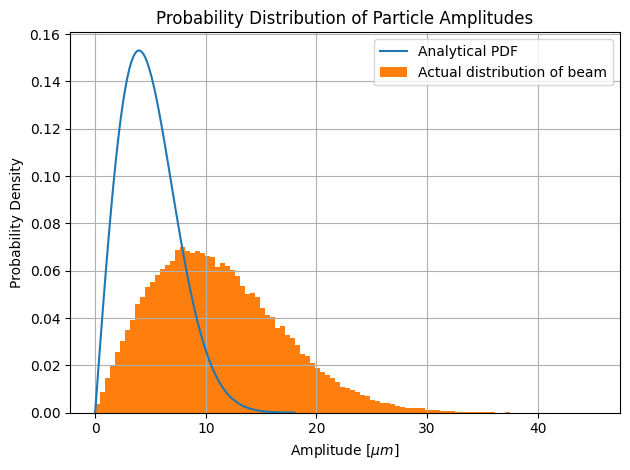

In [3]:
#plt.hist(beam.xs()**2, bins = 100)
x_2 = np.linspace(0,2e-9,100)
gamma = source.energy*SI.e/SI.m_e/SI.c**2
kp = pp.k_p(stage.plasma_density)
#plt.plot(x_2, np.exp(-x_2/(np.sqrt(2/gamma)*source.emit_nx/kp)))
#plt.yscale('log')
sig_x = np.sqrt(np.sqrt(2/gamma)*source.emit_nx/kp)*1e6
fig, ax = plt.subplots(tight_layout = True)

A = np.sqrt(beam.xs()**2 + beam.xps()**2*source.beta_x**2)*1e6
A_lin = np.linspace(0,1.8e-5, 100)*1e6
A_prob = A_lin/sig_x**2*np.exp(-0.5*A_lin**2/sig_x**2)
ax.plot(A_lin,A_prob, label = 'Analytical PDF')
ax.hist(A, bins = 100, density = True, stacked=True, label = 'Actual distribution of beam')
ax.grid()
ax.set_xlabel('Amplitude [$\mu m$]')
ax.set_ylabel('Probability Density')
ax.set_title('Probability Distribution of Particle Amplitudes')
ax.legend()
plt.show()
fig.savefig('PDF_amplitudes')
#print('sig_x² = ', np.sqrt(2/gamma)*source.emit_nx/kp)
#print(np.sqrt(np.mean(A**2)))
#print((np.mean(A**2))/sig_x**2)
#print(np.trapz(A_lin/sig_x**2*np.exp(-0.5*A_lin**2/sig_x**2),A_lin))

### Run simulations

In [ ]:
start = time.time()
linac.run(f'linac_example_new_solver_RR_{stage.radiation_reaction}', num_shots=shots, overwrite=True, parallel=False);
end = time.time()

print((end - start)/60, ' min') # time in minutes

>> SHOT 1/50
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 0.0% rms, 160.4/0.6 µm-rad)
Number of cores: 16
time =  169.17619585990906  sec
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 1530.4 GeV, -1.60 nC, 0.1% rms, 160.1/0.6 µm-rad)
>> SHOT 2/50
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 0.0% rms, 159.4/0.6 µm-rad)
Number of cores: 16
time =  125.39497232437134  sec
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 1530.4 GeV, -1.60 nC, 0.1% rms, 159.2/0.6 µm-rad)
>> SHOT 3/50
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 0.0% rms, 160.8/0.6 µm-rad)
Number of cores: 16
time =  149.32298588752747  sec
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 1530.4 GeV, -1.60 nC, 0.1% rms, 160.5/0.6 µm-rad)
>> SHOT 4/50
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 0.0% rms, 160.4/0.6 µm-rad)
Number of cores: 16
time =  84.73700499534607  

In [ ]:
Final_energies = [linac.get_beam(-1, shot = i).energy()/1e9 for i in range(shots)]
Final_spread = [linac.get_beam(-1, shot = i).rel_energy_spread() for i in range(shots)]
energy_standard_error = np.std(Final_energies)
mean_energy = np.mean(Final_energies)
print('RMS energy spread is ', energy_standard_error, 'Mean final energy is ', mean_energy)

gamma = source.energy*SI.e/SI.m_e/SI.c**2
kp = pp.k_p(stage.plasma_density)
k_beta = kp/np.sqrt(2*gamma)
sig_x2 = (np.sqrt(2/gamma)*source.emit_nx/kp)
sig_y2 = (np.sqrt(2/gamma)*source.emit_ny/kp)

Expected_energy_loss = SI.e**2/6/np.pi/SI.epsilon_0 * (gamma*k_beta)**4*(sig_x2+sig_y2)*stage.length
Expected_energy_spread = SI.e**2/6/np.pi/SI.epsilon_0 * (gamma*k_beta)**4*\
np.sqrt((sig_x2**2+sig_y2**2))*stage.length/(source.energy*SI.e)

print('expected energy loss is ', Expected_energy_loss/SI.e/1e9)
print('expected energy spread is ', Expected_energy_spread)
print('actual energy spread is ', np.mean(Final_spread), \
      'standard error in energy spread is ', np.std(Final_spread))

### Plot the wakefield

In [ ]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

In [ ]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

In [ ]:
linac.stages[0].plot_wake()
linac.stages[-1].plot_wake()

In [ ]:
#fig = linac.stages[0].plot_evolution()
fig_last = linac.stages[-1].plot_evolution()

### Plot beam evolution and survey

In [ ]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False)
linac[0].plot_waterfalls()


In [ ]:
linac.animate_lps()

![](run_data/linac_example/plots/lps_shot0.gif)

In [ ]:
stage_num = 15
shot_num = 0
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [ ]:
stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)